In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from typing import Tuple, List, Type, Dict, Any

In [8]:
class SimpleMLP(torch.nn.Module):
    
    def __init__(self):

        super().__init__()

        # [X] ~ 784 -> (\theta1 X)=[z1] ~ 128 -> act() -> [h1] ~ 128 ->
        # -> (\theta2 h1)=[z2] ~ 32 -> act() -> [h2] ~ 32 ->
        # -> (\theta3 h2)=[z3] ~ 10 -> softmax() -> [p] ~ 10

        self.a = torch.nn.ReLU()
        self.l1 = torch.nn.Linear(784, 128)
        self.l2 = torch.nn.Linear(128, 32)
        self.l3 = torch.nn.Linear(32, 10)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1) # B x 28 x 28 -> B x 784
        z1 = self.l1(x) # ~ 128
        h1 = self.a(z1) # ~ 128
        z2 = self.l2(h1) # ~ 32
        h2 = self.a(z2) # ~ 32
        z3 = self.l3(h2) # ~ 10
        
        return z3

In [ ]:
0      1      2    3  ... 9
10,   20,   -45,  76, ... 80 - "логиты"
0.1, 0.2, 0.001, 0.3, ... 0.4 - "оценки вероятностей"

In [9]:
mlp = SimpleMLP()

In [10]:
mlp

SimpleMLP(
  (a): ReLU()
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=32, bias=True)
  (l3): Linear(in_features=32, out_features=10, bias=True)
)

In [11]:
print('Total number of trainable parameters', 
      sum(p.numel() for p in mlp.parameters() if p.requires_grad))

Total number of trainable parameters 104938


In [13]:
class MLP(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 input_channels: int = 1, 
                 hidden_layer_features: List[int] = [256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10):

        super().__init__()

        network_layers = []
        in_features = np.product(input_resolution) * input_channels

        for out_features in hidden_layer_features:
            network_layers.append(torch.nn.Linear(in_features, out_features))
            network_layers.append(activation())
            in_features = out_features
            
        network_layers.append(torch.nn.Linear(in_features, num_classes))
        self._layers = torch.nn.Sequential(*network_layers)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self._layers.forward(x) # вычислили логиты / logits

In [3]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader,
                       tb_writer: SummaryWriter,
                       epoch: int,
                       batch_size: int):
    train_loss = []
    batch_averaged_loss = []
    model.train()
    for idx,(batch_data, batch_labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
        optimizer.zero_grad()
#         data_gpu, labels_gpu = batch_data.cuda(), batch_labels.cuda()
        data_gpu, labels_gpu = batch_data, batch_labels
        output = model(data_gpu) # B x 10
        loss = loss_function(output, labels_gpu)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss.append(loss.item())
        batch_averaged_loss.append(loss.item())
        if idx % 20 == 0:
            batch_averaged_loss_ = np.sum(batch_averaged_loss)/len(batch_averaged_loss)
            tb_writer.add_scalar('train_batch_loss', batch_averaged_loss_, global_step = epoch*(int(len(data_loader.dataset)/batch_size))+idx)
    
    for tag, param in model.named_parameters():
        tb_writer.add_histogram('grad/%s'%tag, param.grad.data.cpu().numpy(), epoch)
        tb_writer.add_histogram('weight/%s' % tag, param.data.cpu().numpy(), epoch)
    
    return train_loss

In [4]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, labels in tqdm(data_loader, total=len(data_loader)):
#             data_gpu, labels_gpu = data.cuda(), labels.cuda()
            data_gpu, labels_gpu = data, labels
            output = model(data_gpu) # B x 10
            test_loss += loss_function(output, labels_gpu).sum()
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels_gpu.view_as(pred)).sum()

    return {'loss': test_loss.item() / len(data_loader.dataset),
            'accuracy': correct.cpu().numpy() / len(data_loader.dataset)}

In [14]:
model = MLP(hidden_layer_features=[512, 256, 128, 32], activation=torch.nn.GELU, num_classes=10)
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

MLP(
  (_layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)
Total number of trainable parameters 570602


/tmp/ipykernel_2862/493372231.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  model = MLP(hidden_layer_features=[512, 256, 128, 32], activation=torch.nn.GELU, num_classes=10)


In [2]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(28, 28), scale=(.5, 1.0), ratio=(.8, 1.25)),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=train_transforms)

val_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=val_transforms)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:08<00:00, 1.13MB/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 254kB/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.15MB/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 4.24MB/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



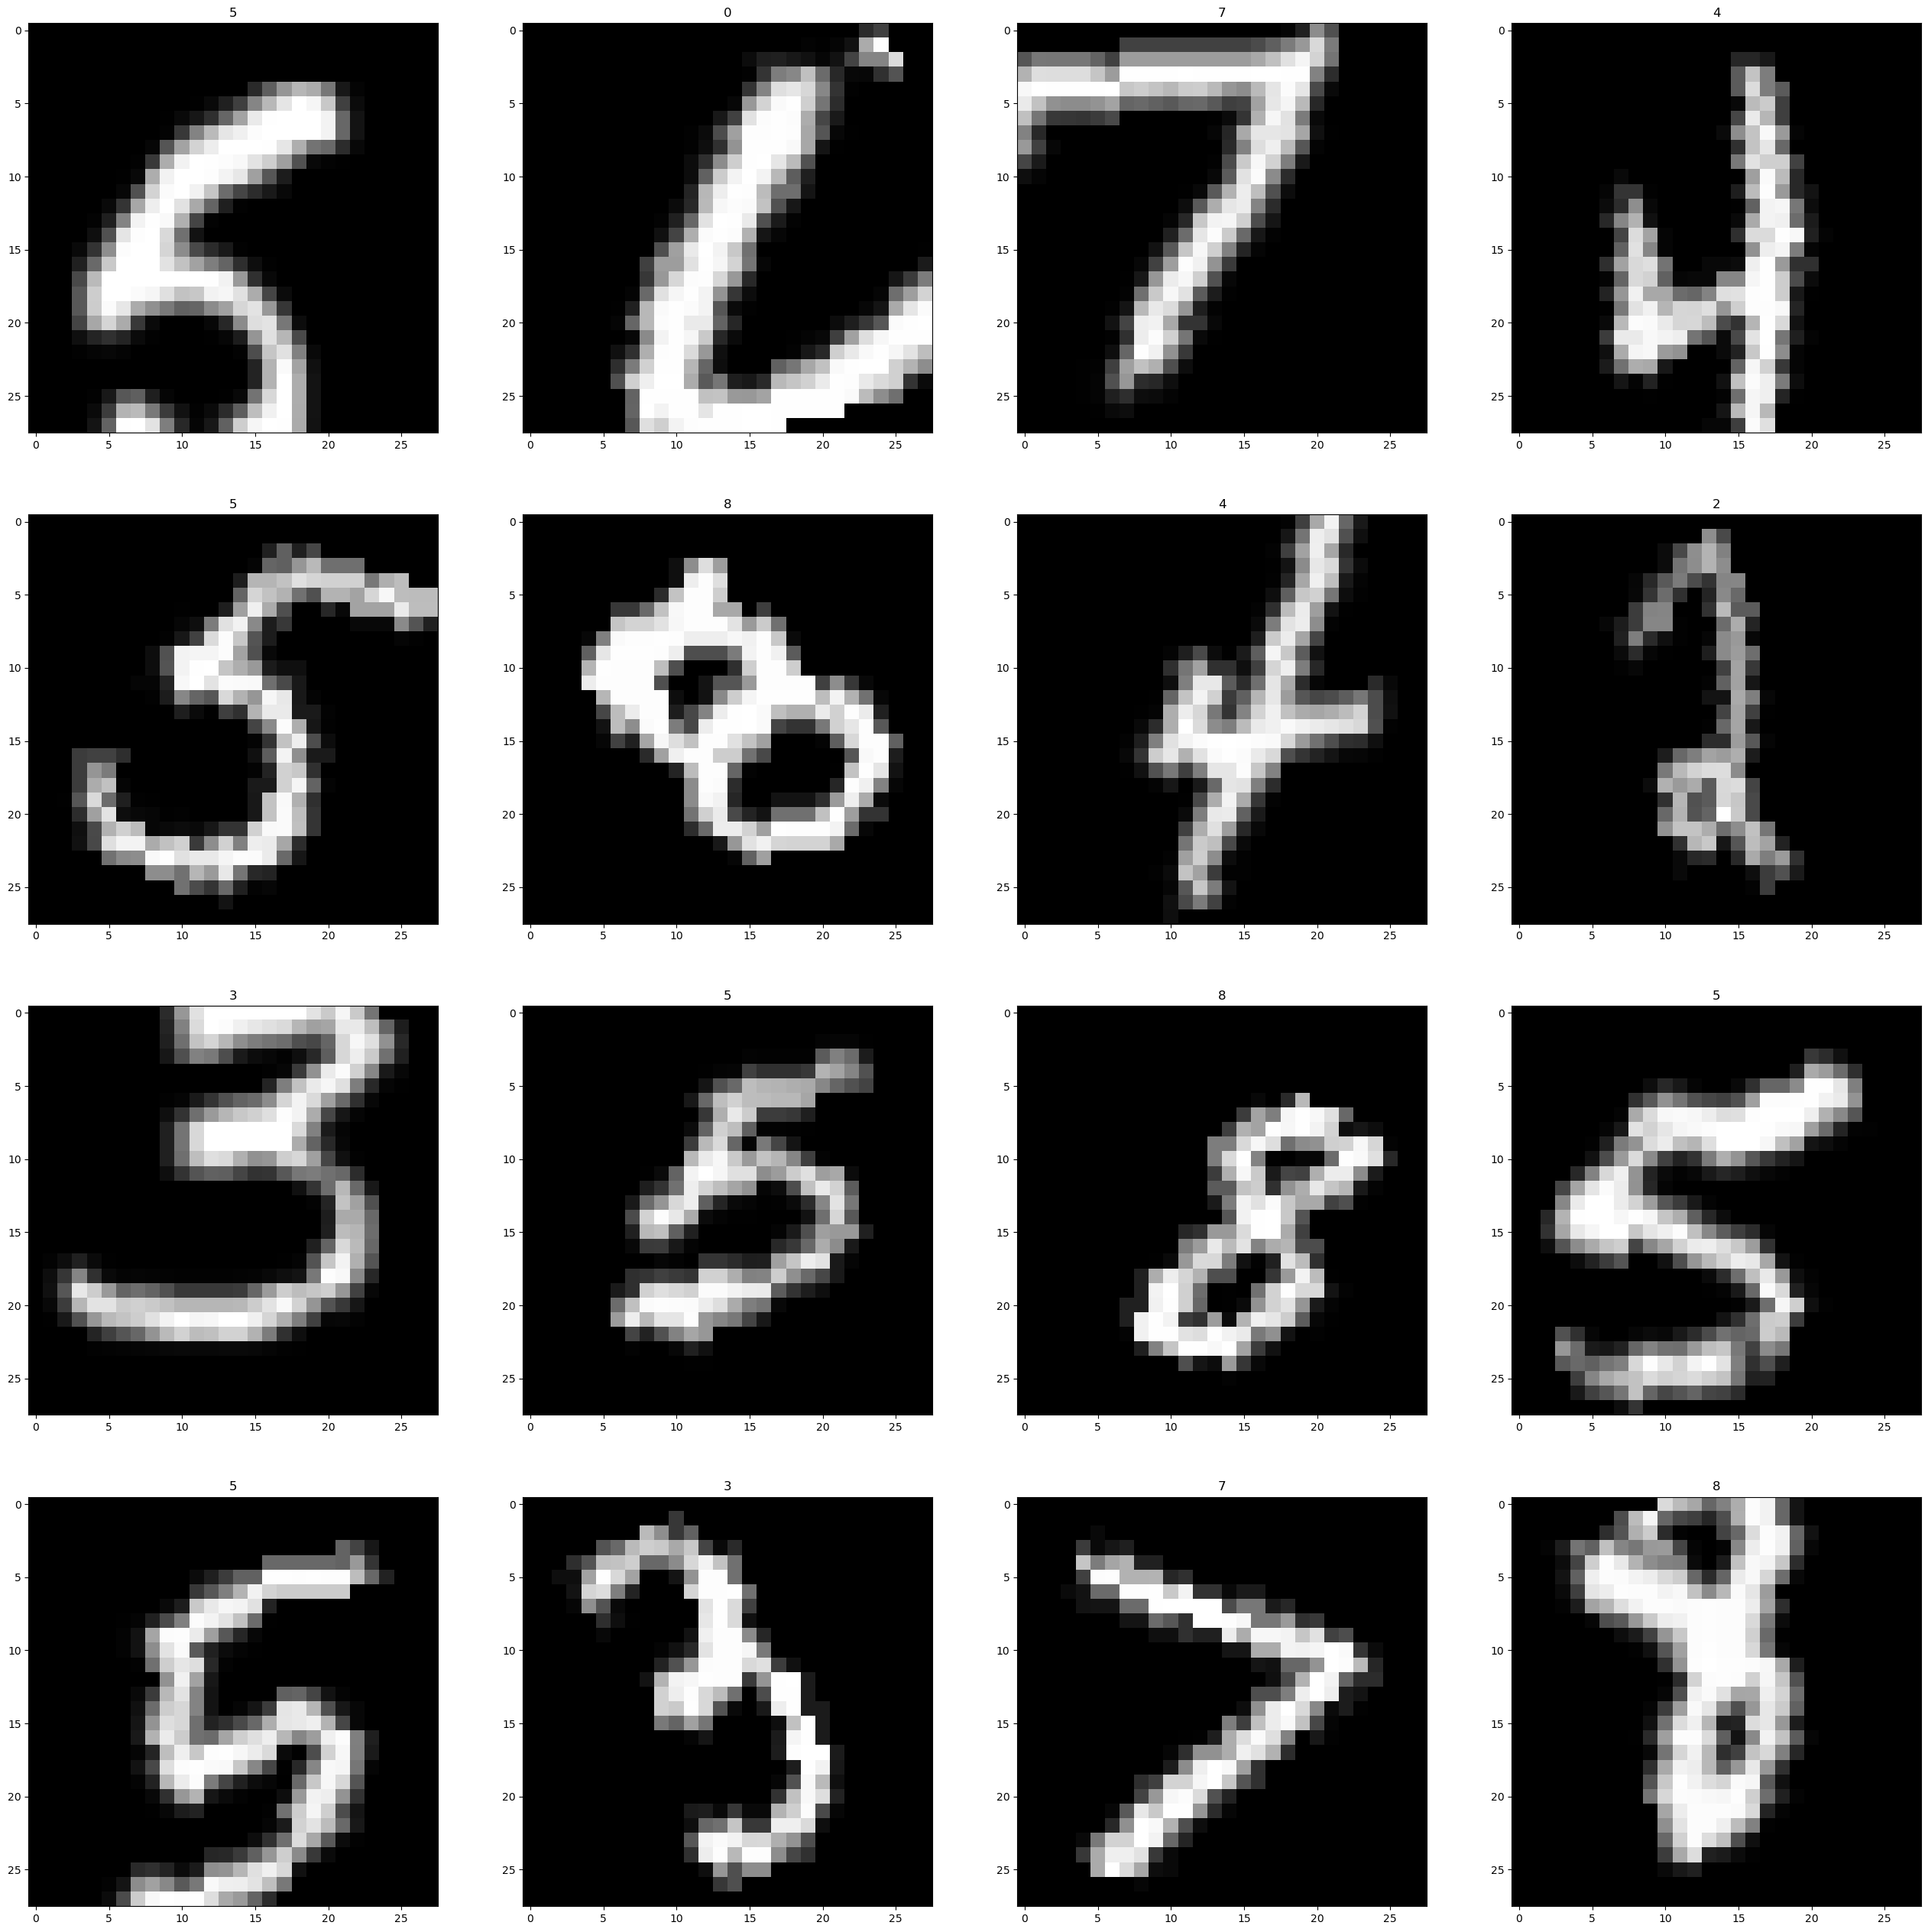

In [4]:
indices = np.random.randint(0, len(train_dataset), size=256)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(32, 32))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*4+j]
        sample, label = train_dataset[sample_index]
        ax.imshow(np.squeeze(sample.cpu().numpy().transpose(1, 2, 0)), cmap='gray')
        ax.set_title(label)
plt.show();

In [45]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 10,
                early_stopping_patience = 10):
    
    #region TENSORBOARD tutorial
    tb_writer = SummaryWriter(log_dir='./logs/run001/')
    #endregion ##############################
    
    #region borrowed from HW03
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    
    loss_history = []
    #endregion borrowed from HW03
    
    for epoch in range(max_epochs):
        #region borrowed from HW03
        print(f'Epoch {epoch}')
        train_epoch_loss_history = train_single_epoch(model,
                                                      optimizer,
                                                      loss_function,
                                                      train_loader,
                                                      tb_writer,
                                                      epoch,
                                                      batch_size=batch_size) # 469
        loss_history = loss_history+train_epoch_loss_history
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        #endregion ##############################
        
        #region TENSORBOARD tutorial
        tb_writer.add_scalar('train_loss', np.sum(train_epoch_loss_history)/len(train_loader.dataset), global_step=epoch)
        tb_writer.add_scalar('val_loss', val_metrics['loss'], global_step=epoch)
        tb_writer.add_scalar('val_accuracy', val_metrics['accuracy'], global_step=epoch)
        #endregion ##############################
        
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            break
    return loss_history

In [46]:
loss_evolution = train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.0001,
            max_epochs=10,
            batch_size=128)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.79it/s]


Validation metrics: 
{'loss': 0.0035288082122802733, 'accuracy': 0.887}
Best model yet, saving
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.99it/s]


Validation metrics: 
{'loss': 0.002121341133117676, 'accuracy': 0.9293}
Best model yet, saving
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.01it/s]


Validation metrics: 
{'loss': 0.0016082036972045897, 'accuracy': 0.943}
Best model yet, saving
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.66it/s]


Validation metrics: 
{'loss': 0.0013618000030517579, 'accuracy': 0.9511}
Best model yet, saving
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.97it/s]


Validation metrics: 
{'loss': 0.0013502988815307618, 'accuracy': 0.9506}
Best model yet, saving
Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.68it/s]


Validation metrics: 
{'loss': 0.001096207332611084, 'accuracy': 0.9595}
Best model yet, saving
Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.93it/s]


Validation metrics: 
{'loss': 0.0009934268951416016, 'accuracy': 0.9618}
Best model yet, saving
Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.70it/s]


Validation metrics: 
{'loss': 0.0010711310386657714, 'accuracy': 0.9593}
Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.49it/s]


Validation metrics: 
{'loss': 0.0009249656677246094, 'accuracy': 0.9652}
Best model yet, saving
Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.66it/s]

Validation metrics: 
{'loss': 0.0008363655090332031, 'accuracy': 0.9672}
Best model yet, saving


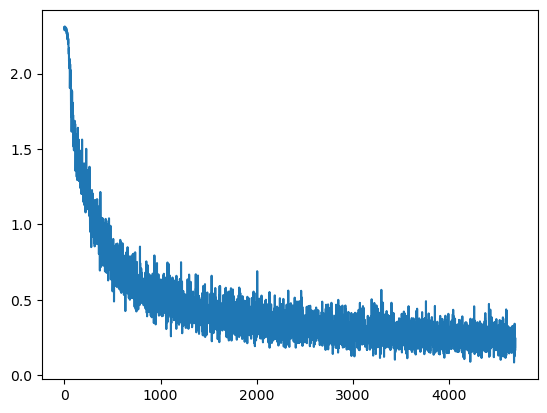

In [47]:
plt.plot(loss_evolution)